# This notebook is analzying the spectral parameters from the frontal EEG channels pre and post MST.

We are only including frontal because we are basing our analyses off of Smith, 2022, in which their dataset only uses fronto-central channels. Additionally, the treatment is targeted to frontal/central areas.

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
from statsmodels.formula.api import ols
from scipy.stats import ttest_rel, zscore
from pingouin import ttest, normality, wilcoxon
from cliffs_delta import cliffs_delta

from mst_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

In [2]:
%matplotlib inline

### Functions

In [3]:
def perm_test(df, feature='', nreps=10000, seed=256, plot_hist=True, run_ttest=True):
    '''permutation test from https://www.uvm.edu/\~statdhtx/StatPages/\
    ResamplingWithR/RandomMatchedSample/RandomMatchedSampleR.html
    '''
    
    means_pre = df[df['pre_post']=='pre'][feature].values
    means_post = df[df['pre_post']=='post'][feature].values
    
    diff_obt = np.nanmedian(means_post) - np.nanmedian(means_pre)
    difference = means_post-means_pre
    
    np.random.seed(seed)
    resamp_mean_diff = np.zeros(nreps)

    for i in range(0, nreps):
        signs = np.random.choice([1, -1], len(difference), replace=True)
        resamp = difference * signs
        resamp_mean_diff[i] = np.nanmedian(resamp)

    diff_obt = abs(diff_obt)
    highprob = len(resamp_mean_diff[resamp_mean_diff >= diff_obt])/nreps
    lowprob = len(resamp_mean_diff[resamp_mean_diff <= -diff_obt])/nreps
    prob2tailed = lowprob + highprob

    print("The probability from the sampling statistics is = ",prob2tailed,'\n')

    if plot_hist:
        plt.hist(resamp_mean_diff, bins=30);
        plt.title(feature)
        plt.xlabel('Median Difference')
        plt.axvline(x=diff_obt, c='r')
        plt.axvline(x=-diff_obt, c='r')

    # compare to student's t-test
    if run_ttest:
        print(ttest(means_pre, means_post, paired=True))

In [4]:
FRONTAL_ONLY = False

In [5]:
# load dataframe
exp_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col = 0)

# Exclude channels from ppn's with bad fits
exp_df_included = exp_df[exp_df['exclude']==False]


In [6]:
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']

frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']

if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]
else:
    exp_df_included = exp_df_included

## Load SpecParam Fits

In [7]:
fits_pre = np.load('../saved_files_appeal/mst_files/mst_fits_pre.npy')
fits_post = np.load('../saved_files_appeal/mst_files/mst_fits_post.npy')
freq_axis = np.load('../saved_files_appeal/mst_files/mst_freq_axis.npy')

**Correct for excluded fits**

In [8]:
# get boolean area with True to exclude channels from patients
to_exclude_pre = exp_df['exclude'][exp_df['pre_post']=='pre'].values
to_exclude_post = exp_df['exclude'][exp_df['pre_post']=='post'].values

# reshape fits array from [23, 60,99] --> [1390, 99]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])

# replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])

## Load PSD's

In [9]:
psd_pre = np.load('../saved_files_appeal/mst_files/pre_mst_psd.npy')
psd_post = np.load('../saved_files_appeal/mst_files/post_mst_psd.npy')

**Correct for excluded PSD's**

In [10]:
# reshape psd array from [23, 60,99] --> [1390, 99]
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# replace to excluded ones with nans
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# reshape back to original array from  [1390, 99] --> [23, 60,99]
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

### Replace NaN's with 0's for oscillatory amplitude (aperiodic adjusted)

There are so few delta oscillations, that we cannot run statistics (later on) using delta_amp. Therefore, we want to put a value instead of a NaN, and say that no oscillation = 0 mV. 

We may not end up using this no nan dataframe, and simply use permutation testing instead, but keeping this here just in case.

In [11]:
df_include_nonan = exp_df_included.copy()
df_include_nonan['delta_amp'] = df_include_nonan['delta_amp'].fillna(0)
df_include_nonan['theta_amp'] = df_include_nonan['theta_amp'].fillna(0)
df_include_nonan['alpha_amp'] = df_include_nonan['alpha_amp'].fillna(0)
df_include_nonan

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
0,9,pre,FP1,NaN,NaN,0.0,-11.283243,6.160561,3.012282,0.722517,-11.315310,9.540913,2.163893,1.129194,-11.300131,-10.910216,1.385597,0.068730,0.981048,False
1,9,pre,FPZ,NaN,NaN,0.0,-11.311451,6.265365,3.086557,0.733975,-11.328971,9.583599,2.081748,1.151045,-11.294941,-10.944674,1.359475,0.069224,0.980534,False
2,9,pre,FP2,NaN,NaN,0.0,-11.285025,NaN,NaN,0.000000,-11.403185,8.828444,5.516757,0.979455,-11.320865,-10.902679,1.417495,0.073972,0.978797,False
3,9,pre,AF3,NaN,NaN,0.0,-11.235786,NaN,NaN,0.000000,-11.160861,10.032387,8.000000,0.986879,-11.267972,-10.919900,1.315336,0.129817,0.947035,False
4,9,pre,AF4,NaN,NaN,0.0,-11.277961,5.176093,1.263650,0.715413,-11.283006,8.727501,4.945225,0.997578,-11.301249,-10.889718,1.419578,0.071667,0.979583,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,191,post,PO6,NaN,NaN,0.0,-11.774113,6.139891,3.100660,0.467476,-11.828470,8.800853,1.814433,1.723120,-11.188669,-11.364319,1.234819,0.066362,0.987620,False
2756,191,post,PO8,NaN,NaN,0.0,-11.771589,NaN,NaN,0.000000,-11.868800,9.042060,3.424618,1.501029,-11.254407,-11.341603,1.255972,0.104854,0.968433,False
2757,191,post,O1,NaN,NaN,0.0,-11.757973,4.199002,1.516109,0.395459,-11.809631,8.773147,1.088419,1.721570,-11.278803,-11.430549,1.197102,0.060777,0.987291,False
2758,191,post,OZ,NaN,NaN,0.0,-11.736114,5.705399,1.000000,0.412440,-11.817168,8.694386,1.008885,1.629046,-11.328935,-11.264617,1.344792,0.057019,0.990354,False


## Averaging Over All (*Frontal*) Electrodes Per Subject

**Average over with amplitudes as 0 (i.e. exp_df_mean_nonan)**

In [12]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean_nonan = pd.DataFrame(df_include_nonan.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

**Average over with NaNs (i.e. exp_df_mean)**

In [13]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

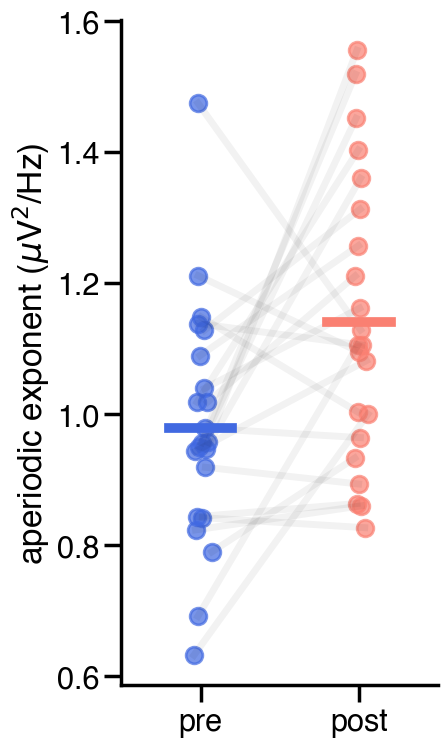

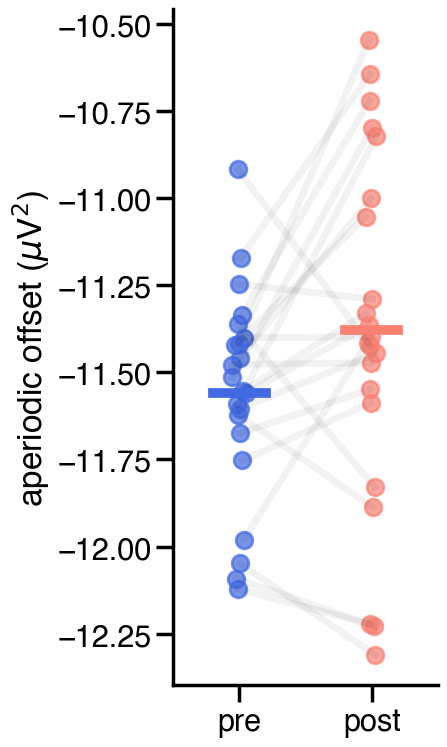

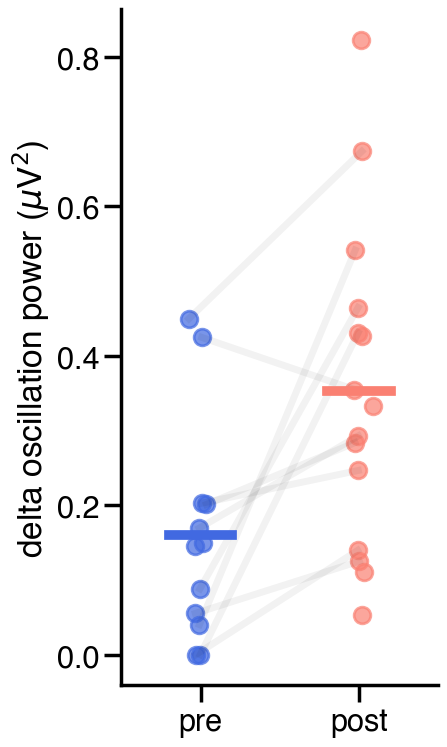

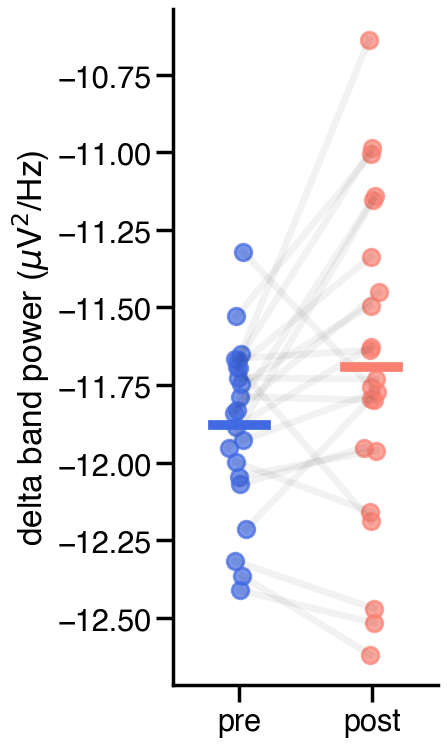

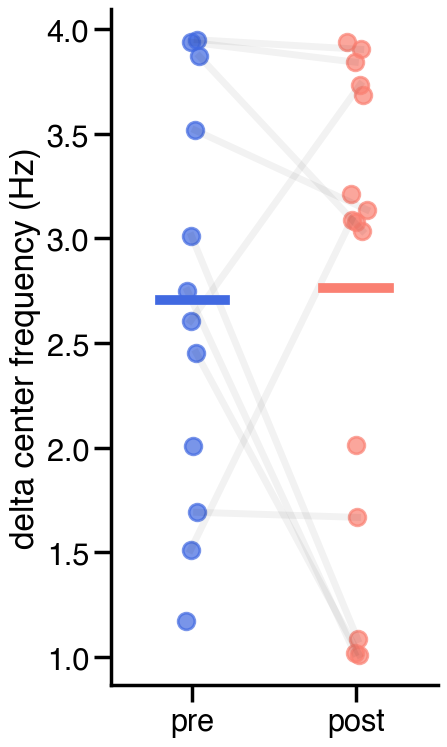

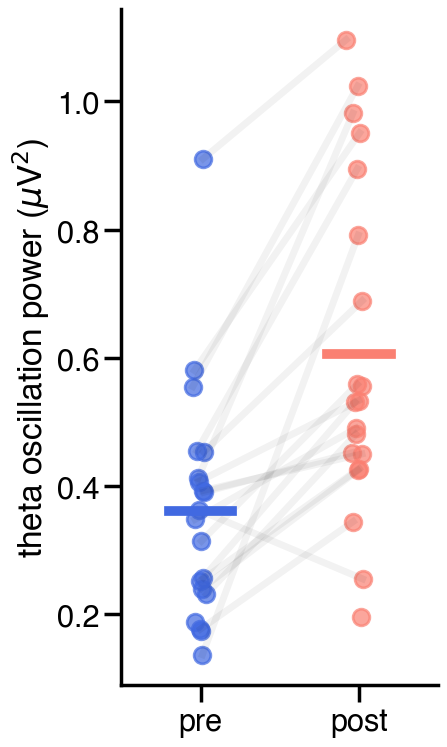

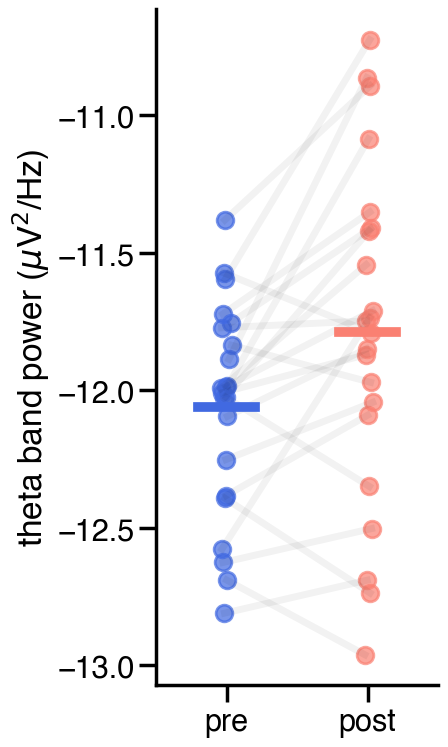

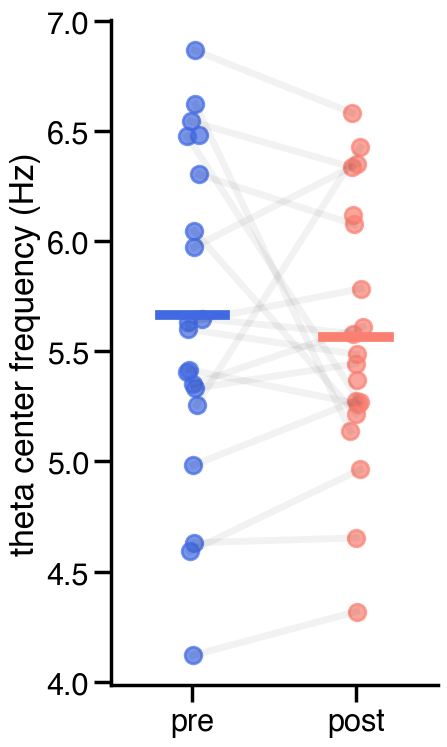

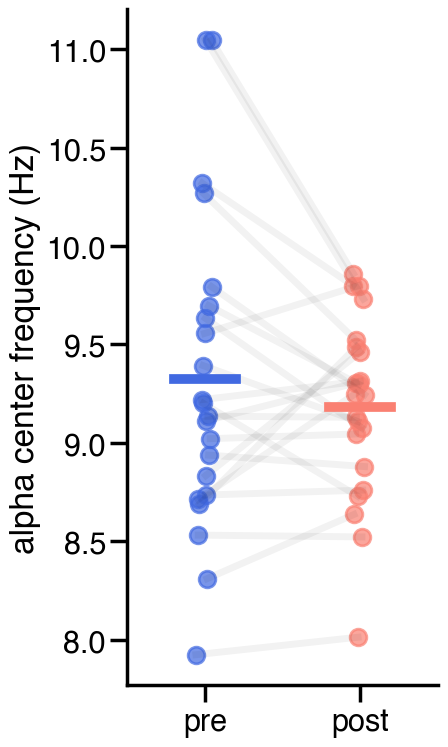

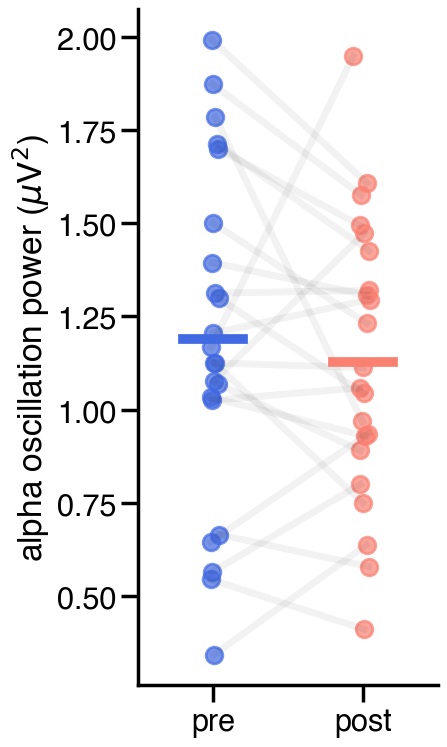

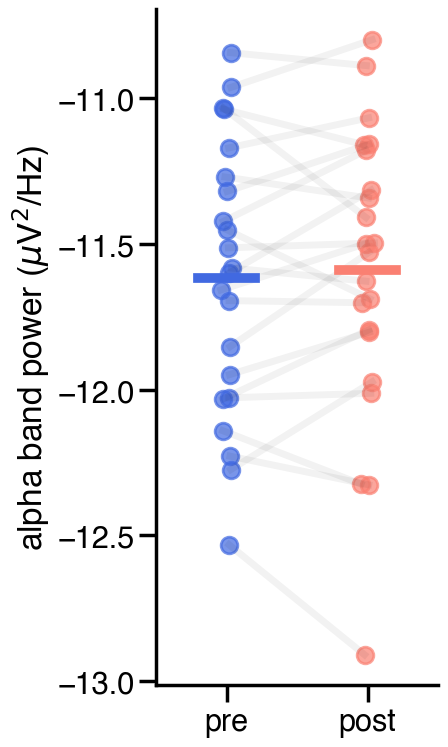

In [14]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'delta_cf', 'theta_amp', 'theta_bp', 'theta_cf',
            'alpha_cf', 'alpha_amp', 'alpha_bp']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)', 'aperiodic offset ($\mu$V$^2$)',
          'delta oscillation power ($\mu$V$^2$)', 'delta band power ($\mu$V$^2$/Hz)', 'delta center frequency (Hz)',
          'theta oscillation power ($\mu$V$^2$)', 'theta band power ($\mu$V$^2$/Hz)', 'theta center frequency (Hz)',
          'alpha center frequency (Hz)', 'alpha oscillation power ($\mu$V$^2$)', 'alpha band power ($\mu$V$^2$/Hz)' ]

for feature, label in zip(features, labels):
    plot_feature_prepost(exp_df_mean, feature=feature)
    plt.ylabel(label)
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

### Figure-Specific Axes

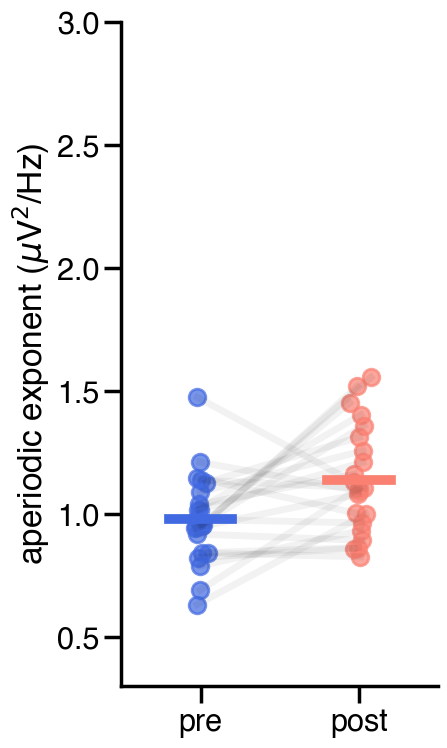

In [15]:
plot_feature_prepost(exp_df_mean, feature='exponent')
plt.ylabel('aperiodic exponent ($\mu$V$^2$/Hz)')
plt.ylim(0.3, 3.0)
sns.despine()
plt.tight_layout()
plt.show()

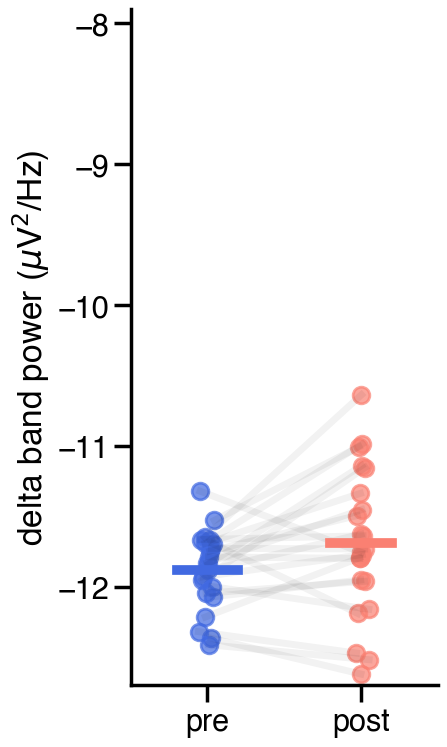

In [16]:
plot_feature_prepost(exp_df_mean, feature='delta_bp')
plt.ylabel('delta band power ($\mu$V$^2$/Hz)')
plt.ylim(-12.7, -7.9)
sns.despine()
plt.tight_layout()
plt.show()

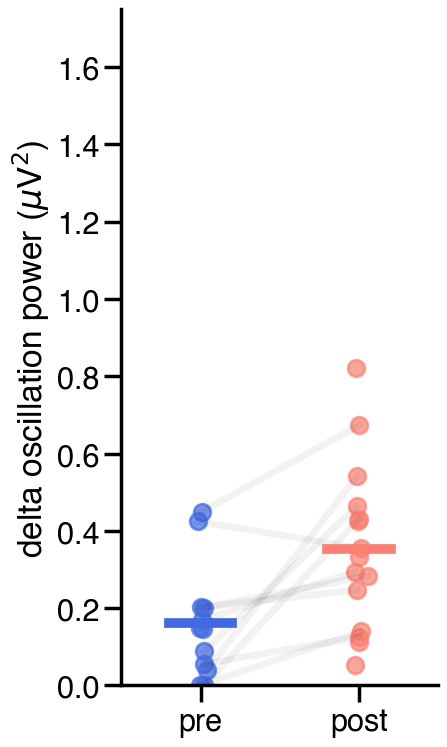

In [17]:
plot_feature_prepost(exp_df_mean, feature='delta_amp')
plt.ylabel('delta oscillation power ($\mu$V$^2$)')
plt.ylim(0, 1.75)
sns.despine()
plt.tight_layout()
plt.show()

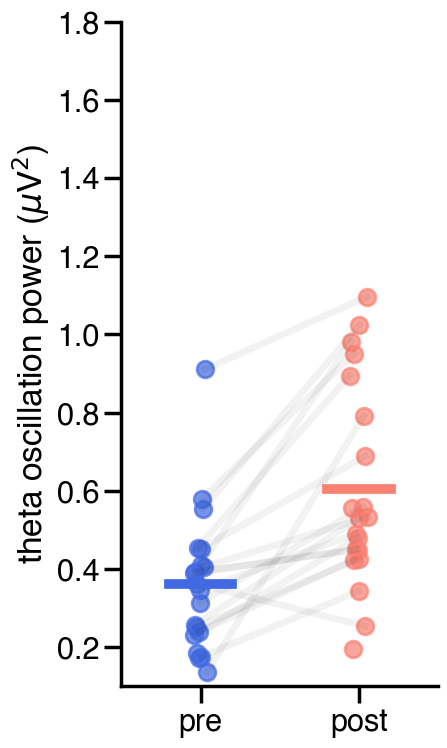

In [18]:
plot_feature_prepost(exp_df_mean, feature='theta_amp')
plt.ylabel('theta oscillation power ($\mu$V$^2$)')
plt.ylim(0.1, 1.8)
sns.despine()
plt.tight_layout()
plt.show()

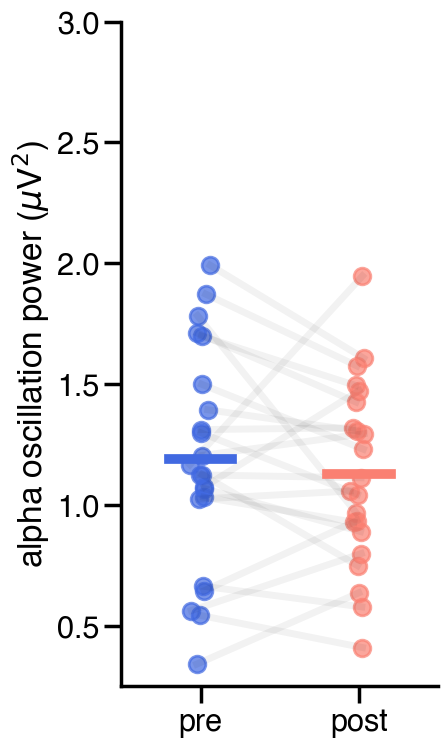

In [19]:
plot_feature_prepost(exp_df_mean, feature='alpha_amp')
plt.ylabel('alpha oscillation power ($\mu$V$^2$)')
plt.ylim(0.25, 3.0)
sns.despine()
plt.tight_layout()
plt.show()

## Plot Spectra

In [20]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11590/1731462785.py:1: RuntimeWarning: Mean of empty slice
  fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11590/1731462785.py:2: RuntimeWarning: Mean of empty slice
  fits_post_mean = np.nanmean(fits_post_included, axis=1)


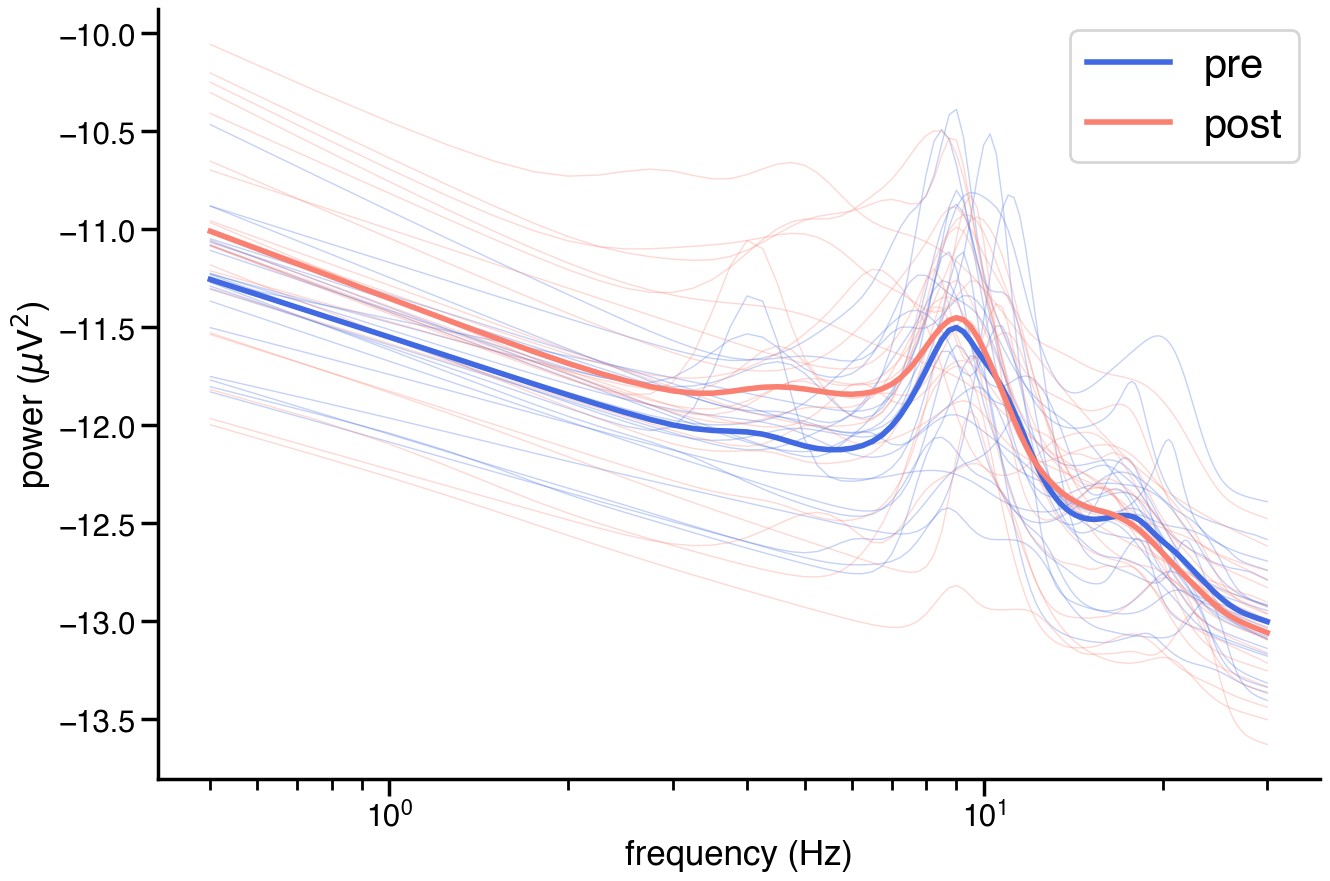

<Figure size 640x480 with 0 Axes>

In [21]:
sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_pre_mean[patient], color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_post_mean[patient], color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], fits_pre_grand_mean, color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], fits_post_grand_mean, color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()
plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

## Plot SpecParam Fits

In [22]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11590/4288182120.py:1: RuntimeWarning: Mean of empty slice
  psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11590/4288182120.py:2: RuntimeWarning: Mean of empty slice
  psd_post_mean = np.nanmean(psd_post_included, axis=1)


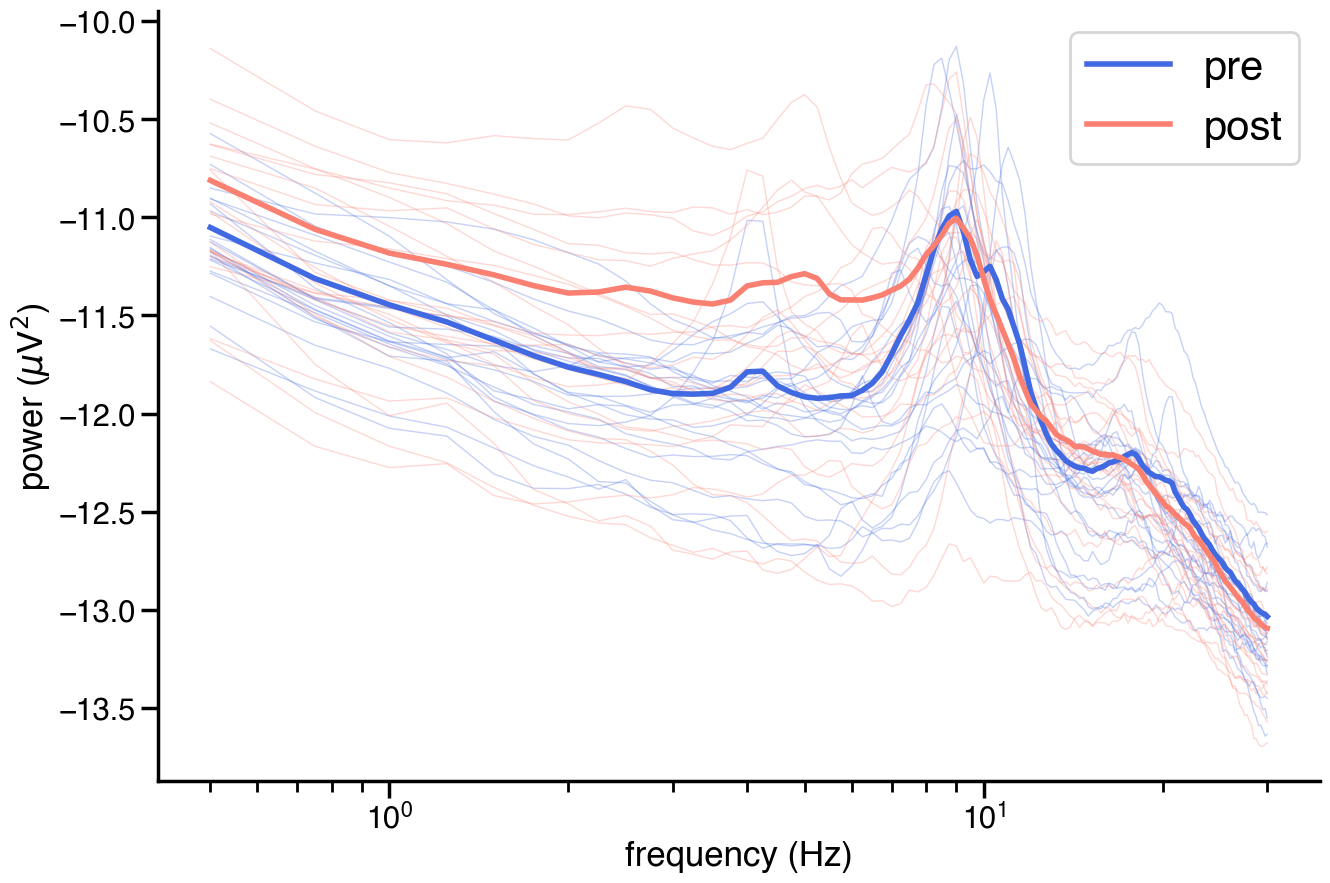

In [23]:
# plot patient pre

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], np.log10(psd_pre_mean[patient,2:121]), color='royalblue', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], np.log10(psd_post_mean[patient,2:121]), color='salmon', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], np.log10(psd_pre_grand_mean[2:121]), color='royalblue', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], np.log10(psd_post_grand_mean[2:121]), color='salmon', linewidth = 4, label='post')


plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})


sns.despine()

plt.show()

# Statistics

### Exponent: Pre/Post

**Normality**

In [24]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['exponent'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.961917  0.528973    True
          W      pval  normal
0  0.950222  0.319066    True


In [25]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 0.98 std: 0.18
post: 1.14 std: 0.21


**Distribution of means pre vs. post**

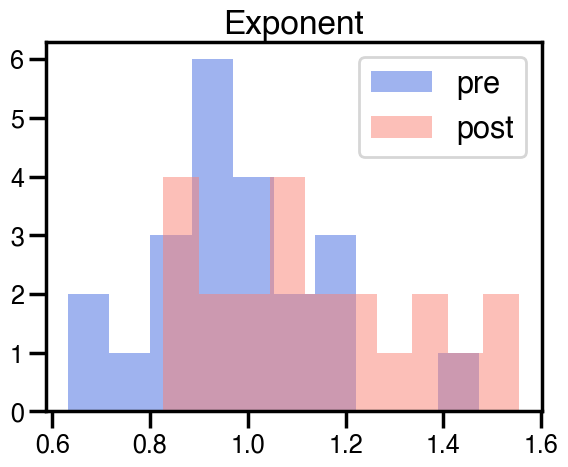

In [26]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Exponent')
plt.show()

**Wilcoxon Test**

In [27]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   45.0   two-sided  0.006649 -0.644269  0.295455


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.001 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -3.056589   21   two-sided  0.005992  [-0.27, -0.05]  0.799083  7.658   

           power  
T-test  0.946496  


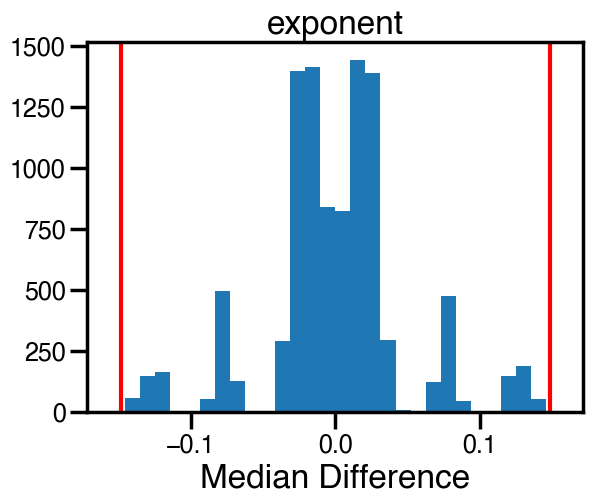

In [28]:
perm_test(exp_df_mean, feature='exponent')

### Offset: Pre/Post

In [29]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['offset'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['offset'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.951137  0.332609    True
          W      pval  normal
0  0.951824  0.343106    True


**Distribution of means pre vs. post**

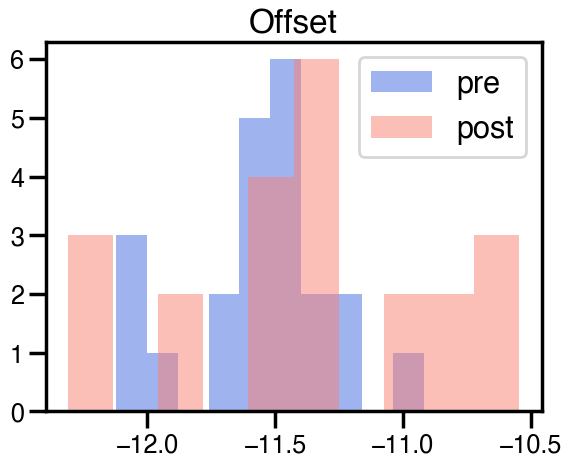

In [30]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Offset')
plt.show()

In [31]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC     CLES
Wilcoxon   67.0   two-sided  0.054245 -0.470356  0.36157


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.2563 

               T  dof alternative   p-val           CI95%   cohen-d   BF10  \
T-test -2.157526   21   two-sided  0.0427  [-0.36, -0.01]  0.434268  1.521   

           power  
T-test  0.493458  


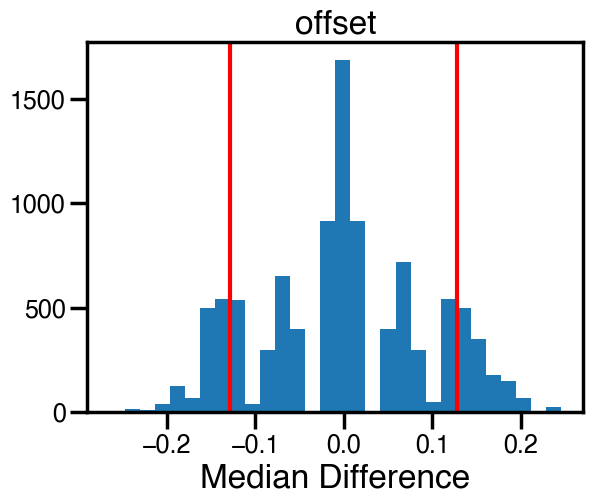

In [32]:
perm_test(exp_df_mean, feature='offset')

### Delta Oscillatory Power: Pre/Post

**Normality**

In [33]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.869281  0.063993    True
          W      pval  normal
0  0.955652  0.617365    True


In [34]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.16 std: 0.14
post: 0.35 std: 0.21


**Distribution of means pre vs. post**

This one is tricky to do stats for because the pre has so few channels that even detect a delta oscillation. When we try to keep the 0's instead of NaNs, the Wilcoxon test fails due to 'ties'. Therefore, we are keeping the NaNs, and will just report the permutation test for statistics.

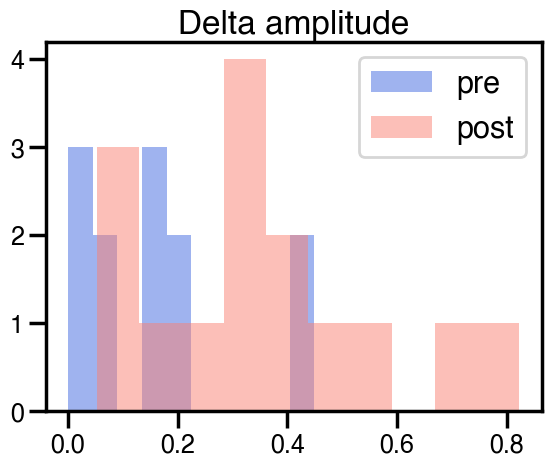

In [35]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta amplitude')
plt.show()

In [36]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC  CLES
Wilcoxon    2.0   two-sided  0.005859 -0.927273  0.19


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -3.262752    9   two-sided  0.009796  [-0.33, -0.06]  1.138635  6.302   

           power  
T-test  0.892036  


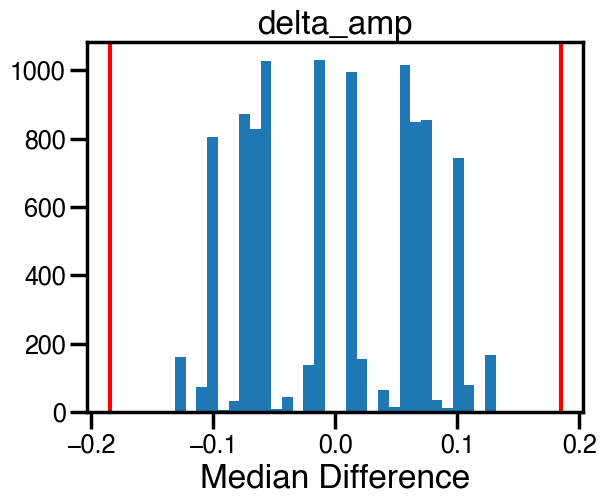

In [37]:
perm_test(exp_df_mean, feature='delta_amp')

### Delta Band Power: Pre/Post

**Normality**

In [38]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.962443  0.540178    True
          W      pval  normal
0  0.978363  0.888588    True


In [39]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.88 std: 0.27
post: -11.69 std: 0.51


**Distribution of means pre vs. post**

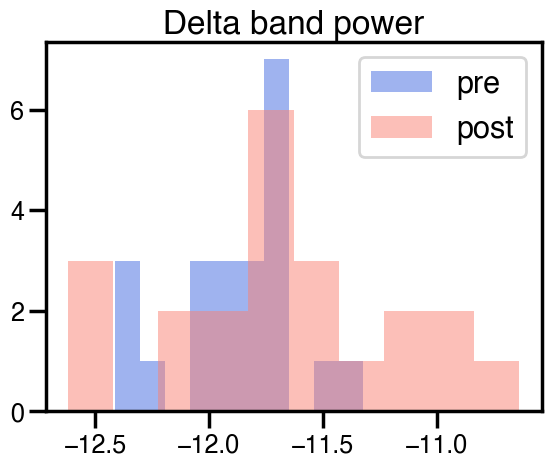

In [40]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta band power')
plt.show()

**Wilcoxon Test**

In [41]:
print(wilcoxon(means_pre, means_post))

          W-val alternative    p-val       RBC      CLES
Wilcoxon   68.0   two-sided  0.05869 -0.462451  0.382231


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.36560000000000004 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.234293   21   two-sided  0.036466  [-0.36, -0.01]  0.452237  1.724   

           power  
T-test  0.525461  


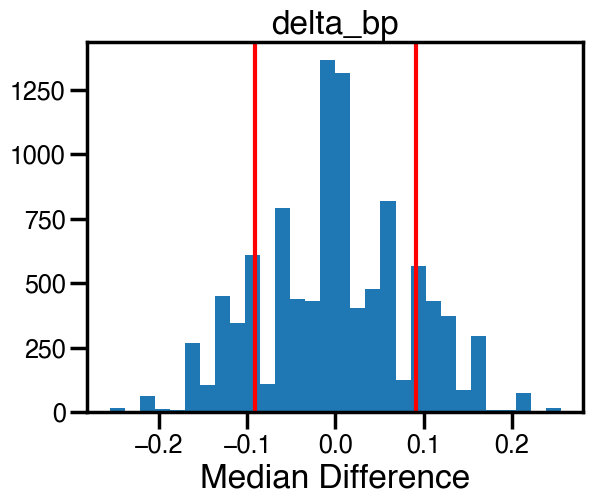

In [42]:
perm_test(exp_df_mean, feature='delta_bp')

### Delta Center Frequency: Pre/Post

**Normality**

In [43]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['delta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['delta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.931574  0.397095    True
          W      pval  normal
0  0.843306  0.013981   False


**Distribution of means pre vs. post**

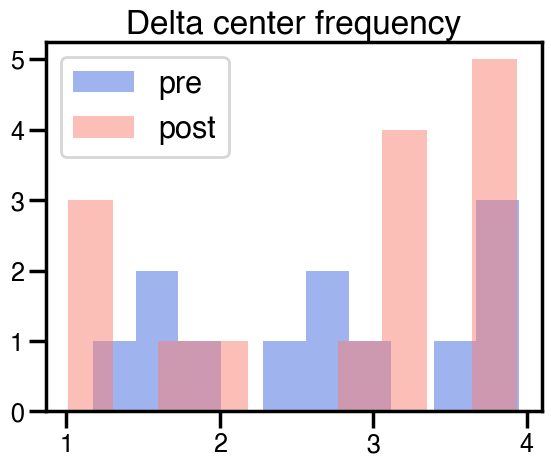

In [44]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Delta center frequency')
plt.show()

**Wilcoxon Test**

In [45]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC  CLES
Wilcoxon   14.0   two-sided  0.193359  0.490909  0.59


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.2089 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  1.033644    9   two-sided  0.328277  [-0.45, 1.2]  0.352497  0.477   

           power  
T-test  0.169842  


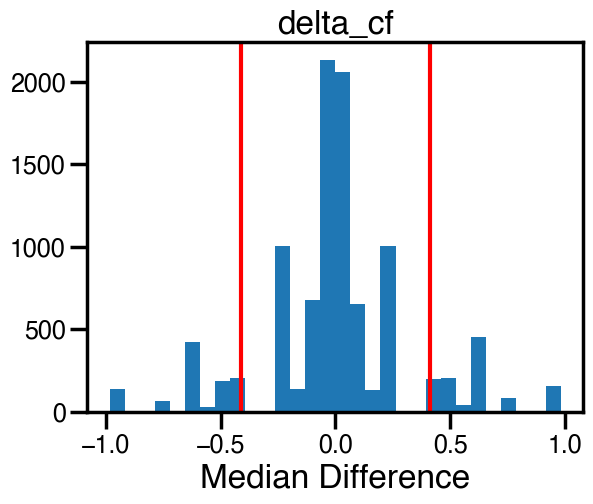

In [46]:
perm_test(exp_df_mean, feature='delta_cf')

### Theta Oscillatory Power: Pre/Post

**Normality**

In [47]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.883664  0.020604   False
          W      pval  normal
0  0.923482  0.115632    True


In [48]:
print('pre: ' + str(round(np.nanmean(means_pre),2)) + ' std: ' + str(round(np.nanstd(means_pre),2)))
print('post: ' + str(round(np.nanmean(means_post),2)) + ' std: ' + str(round(np.nanstd(means_post),2)))

pre: 0.36 std: 0.18
post: 0.61 std: 0.26


In [49]:
print('theta osc pre')
print(exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_amp'].describe())

theta osc pre
count    20.000000
mean      0.361217
std       0.180461
min       0.136073
25%       0.236943
50%       0.354756
75%       0.421651
max       0.910430
Name: theta_amp, dtype: float64


In [50]:
print('theta osc post')
print(exp_df_mean[exp_df_mean['pre_post']=='post']['theta_amp'].describe())

theta osc post
count    20.000000
mean      0.605948
std       0.263550
min       0.195233
25%       0.443773
50%       0.531518
75%       0.817160
max       1.096278
Name: theta_amp, dtype: float64


**Distribution of means pre vs. post**

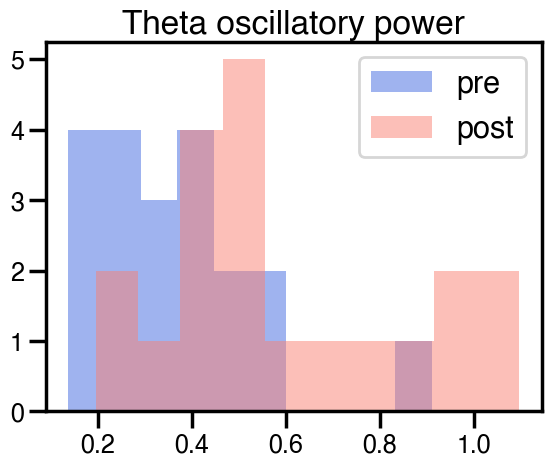

In [51]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta oscillatory power')
plt.show()

**Wilcoxon Test**

In [52]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    3.0   two-sided  0.000038 -0.964912  0.188272


In [53]:
cliffs_delta(means_pre, means_post)

(-0.9793388429752066, 'large')

**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0416 

               T  dof alternative     p-val           CI95%  cohen-d     BF10  \
T-test -5.583235   17   two-sided  0.000033  [-0.34, -0.16]  1.12488  757.583   

           power  
T-test  0.994277  


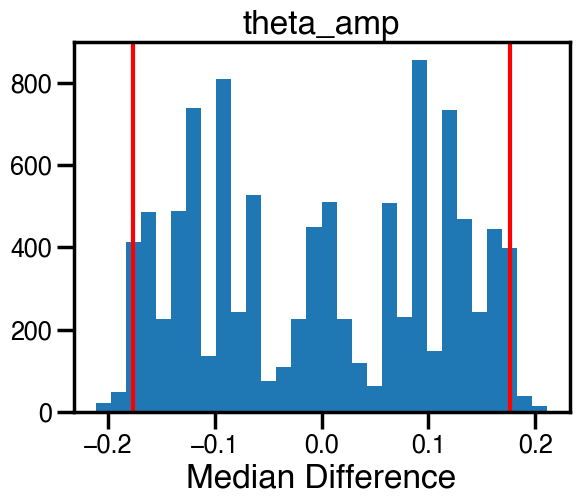

In [54]:
perm_test(exp_df_mean, feature='theta_amp')

### Theta Band Power: Pre/Post

**Normality**

In [55]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.959907  0.487401    True
          W      pval  normal
0  0.973173  0.783219    True


In [56]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -12.06 std: 0.38
post: -11.79 std: 0.6


**Distribution of means pre vs. post**

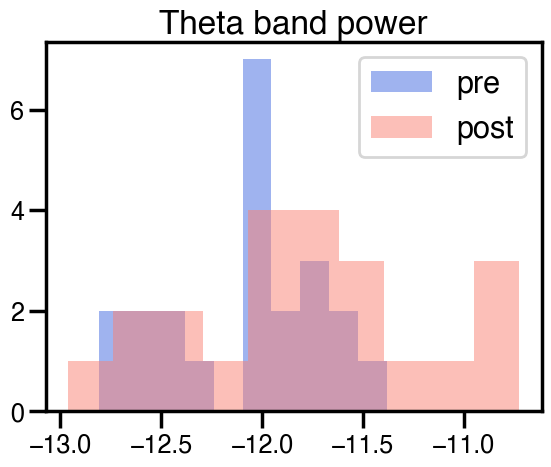

In [57]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta band power')
plt.show()

**Wilcoxon Test**

In [58]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   46.0   two-sided  0.007443 -0.636364  0.347107


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0469 

               T  dof alternative   p-val          CI95%   cohen-d   BF10  \
T-test -3.190482   21   two-sided  0.0044  [-0.45, -0.1]  0.534582  9.958   

           power  
T-test  0.666996  


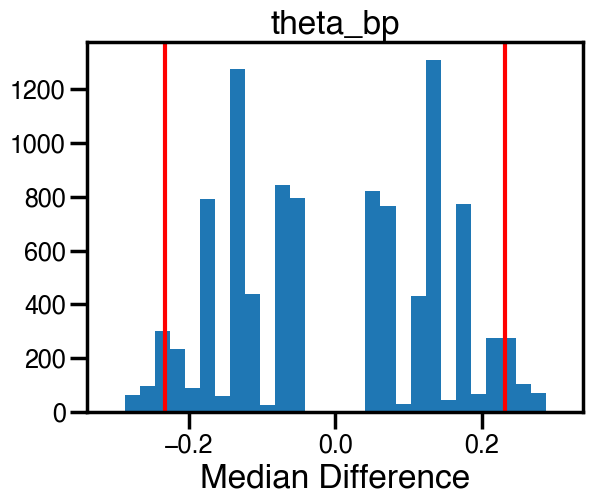

In [59]:
perm_test(exp_df_mean, feature='theta_bp')

### Theta Center Frequency: Pre/Post

**Normality**

In [60]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['theta_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['theta_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.964696  0.641254    True
          W      pval  normal
0  0.963442  0.614657    True


**Distribution of means pre vs. post**

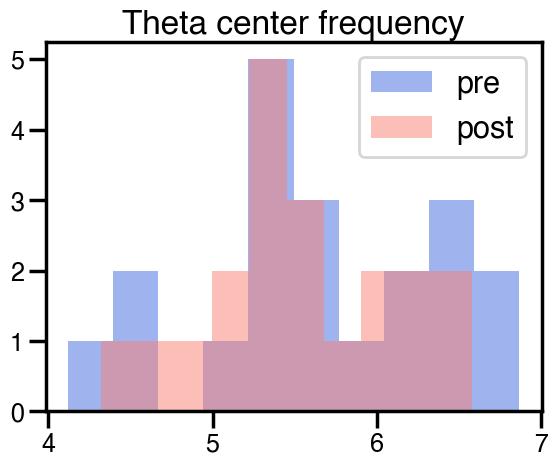

In [61]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Theta center frequency')
plt.show()

**Wilcoxon Test**

In [62]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   81.0   two-sided  0.865044  0.052632  0.552469


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.194 

               T  dof alternative     p-val          CI95%   cohen-d  BF10  \
T-test  0.628497   17   two-sided  0.538032  [-0.21, 0.39]  0.129164  0.29   

           power  
T-test  0.081224  


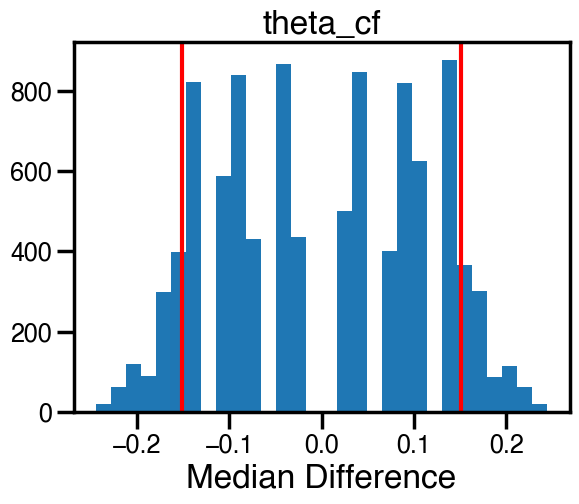

In [63]:
perm_test(exp_df_mean, feature='theta_cf')

### Alpha Oscillatory Power: Pre/Post

**Normality**

In [64]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.964931  0.594794    True
          W      pval  normal
0  0.988872  0.994878    True


In [65]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: 1.19 std: 0.44
post: 1.13 std: 0.37


**Distribution of means pre vs. post**

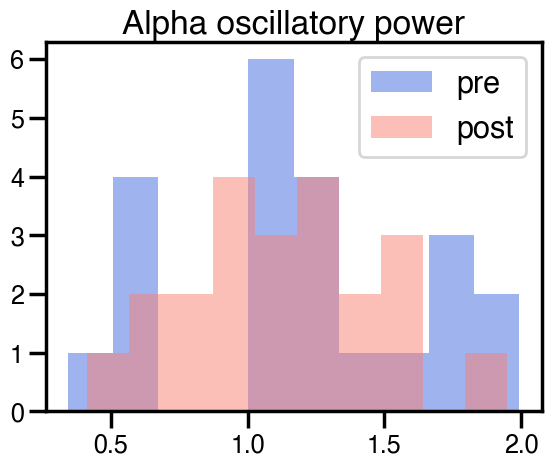

In [66]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha oscillatory power')
plt.show()

**Wilcoxon Test**

In [67]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   93.0   two-sided  0.290223  0.264822  0.549587


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.383 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test  0.875614   21   two-sided  0.391145  [-0.08, 0.21]  0.147294  0.314   

           power  
T-test  0.101164  


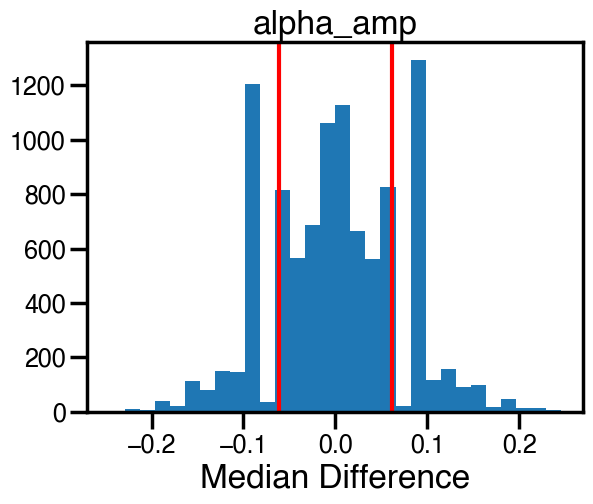

In [68]:
perm_test(exp_df_mean, feature='alpha_amp')

### Alpha Band Power: Pre/Post

**Normality**

In [69]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

         W      pval  normal
0  0.97502  0.823228    True
          W     pval  normal
0  0.958079  0.45146    True


In [70]:
print('pre: ' + str(round(means_pre.mean(),2)) + ' std: ' + str(round(means_pre.std(),2)))
print('post: ' + str(round(means_post.mean(),2)) + ' std: ' + str(round(means_post.std(),2)))

pre: -11.62 std: 0.46
post: -11.59 std: 0.49


**Distribution of means pre vs. post**

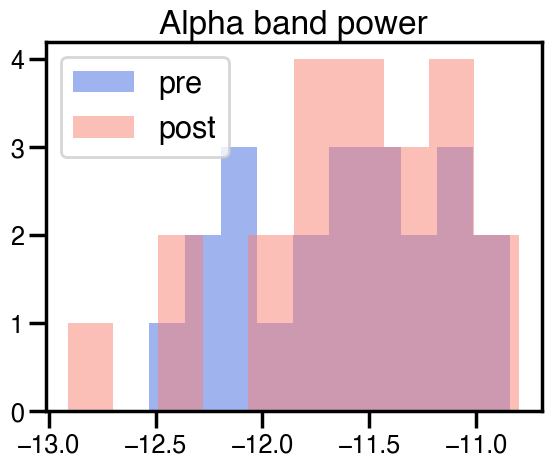

In [71]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha band power')
plt.show()

**Wilcoxon Test**

In [72]:
print(wilcoxon(means_pre, means_post))

          W-val alternative    p-val      RBC     CLES
Wilcoxon  105.0   two-sided  0.50284 -0.16996  0.47314


**Permutation Test + T-Test**

The probability from the sampling statistics is =  0.1527 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.611861   21   two-sided  0.547198  [-0.12, 0.06]  0.055162  0.264   

           power  
T-test  0.057025  


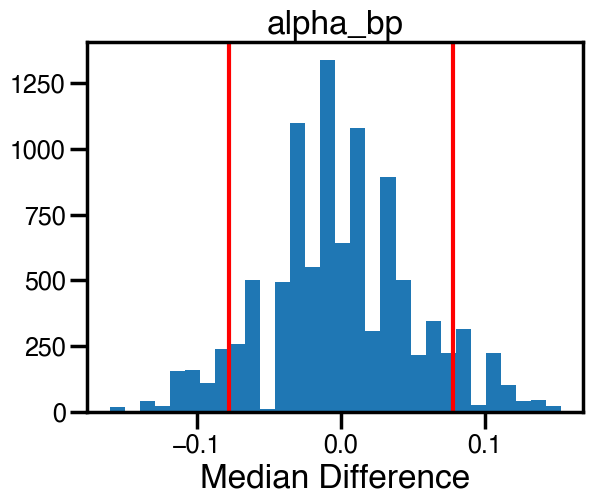

In [73]:
perm_test(exp_df_mean, feature='alpha_bp')

### Alpha Center Frequency: Pre/Post

**Normality**

In [74]:
means_pre = exp_df_mean[exp_df_mean['pre_post']=='pre']['alpha_cf'].values
means_post = exp_df_mean[exp_df_mean['pre_post']=='post']['alpha_cf'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.947693  0.284068    True
          W      pval  normal
0  0.959265  0.474561    True


**Distribution of means pre vs. post**

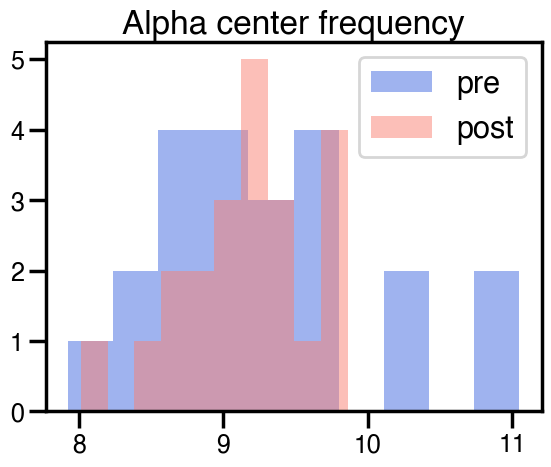

In [75]:
plt.hist(means_pre, color = 'royalblue', alpha = 0.5, label = 'pre')
plt.hist(means_post, color = 'salmon', alpha = 0.5, label = 'post')
plt.legend()
plt.title('Alpha center frequency')
plt.show()

**Wilcoxon Test**

In [76]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon  101.0   two-sided  0.424489  0.201581  0.506198


**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.1671 

               T  dof alternative     p-val         CI95%   cohen-d   BF10  \
T-test  1.239726   21   two-sided  0.228752  [-0.1, 0.38]  0.217396  0.438   

           power  
T-test  0.163645  


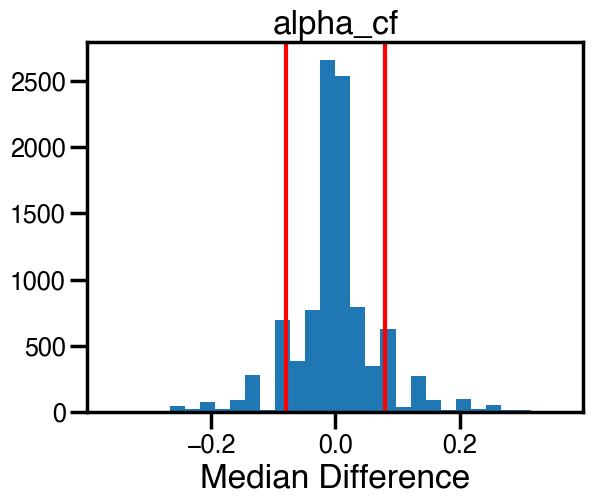

In [77]:
perm_test(exp_df_mean, feature='alpha_cf')

## Presence/Absence/Percentage of Channels with Oscillations

We are determining what % of channels have a delta oscillation per participant, per pre/post

### Delta Percentage

In [78]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = exp_df_included[features]
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11590/259686611.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()


In [79]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a delta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_delta_perc = ch_delta/ch_total

In [80]:
# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc

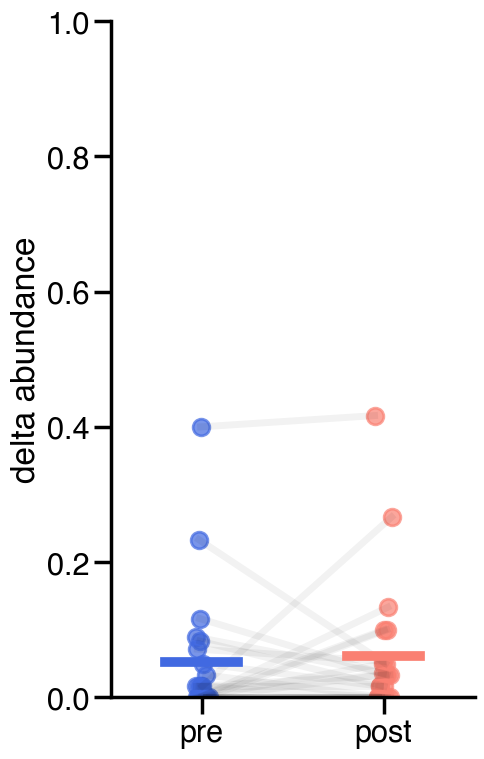

In [81]:
plot_feature_prepost(delta_osc_perc, feature='ch_delta_perc')
plt.ylim(0, 1) # same y axis as ECT
plt.ylabel('delta abundance')
sns.despine()
plt.show()

**Normality**

In [82]:
perc_delta_pre = delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(perc_delta_pre, method='shapiro'))
print(normality(perc_delta_post, method='shapiro'))

          W      pval  normal
0  0.604765  0.000001   False
          W      pval  normal
0  0.635455  0.000003   False


In [83]:
print('pre: ' + str(round(perc_delta_pre.mean(),2)) + ' std: ' + str(round(perc_delta_pre.std(),2)))
print('post: ' + str(round(perc_delta_post.mean(),2)) + ' std: ' + str(round(perc_delta_post.std(),2)))

pre: 0.05 std: 0.09
post: 0.06 std: 0.1


In [84]:
print('delta abundance pre')
print(delta_osc_perc[delta_osc_perc['pre_post']=='pre']['ch_delta_perc'].describe())

delta abundance pre
count    22.000000
mean      0.052002
std       0.095942
min       0.000000
25%       0.000000
50%       0.016667
75%       0.066071
max       0.400000
Name: ch_delta_perc, dtype: float64


In [85]:
print('delta abundance post')
print(delta_osc_perc[delta_osc_perc['pre_post']=='post']['ch_delta_perc'].describe())

delta abundance post
count    22.000000
mean      0.061660
std       0.100524
min       0.000000
25%       0.000000
50%       0.033333
75%       0.052679
max       0.416667
Name: ch_delta_perc, dtype: float64


**Wilcoxon Test**

In [86]:
print(wilcoxon(perc_delta_pre, perc_delta_post))

          W-val alternative     p-val       RBC     CLES
Wilcoxon   62.5   two-sided  0.795921 -0.080882  0.42562


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [87]:
cliffs_delta(perc_delta_pre, perc_delta_post)

(-0.1487603305785124, 'small')

**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0358 

               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -0.530494   21   two-sided  0.601335  [-0.05, 0.03]  0.098287  0.253   

           power  
T-test  0.072488  


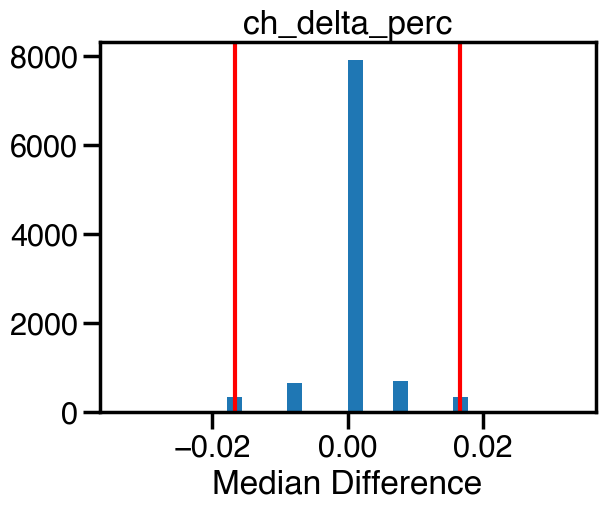

In [88]:
perm_test(delta_osc_perc, feature='ch_delta_perc')

### Theta Percentage

In [89]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = exp_df_included[features]
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11590/2939216184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()


In [90]:
# With this new df, we want to group by the patient/pre_post to show how many channels have a theta oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_theta_perc = ch_theta/ch_total

In [91]:
# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

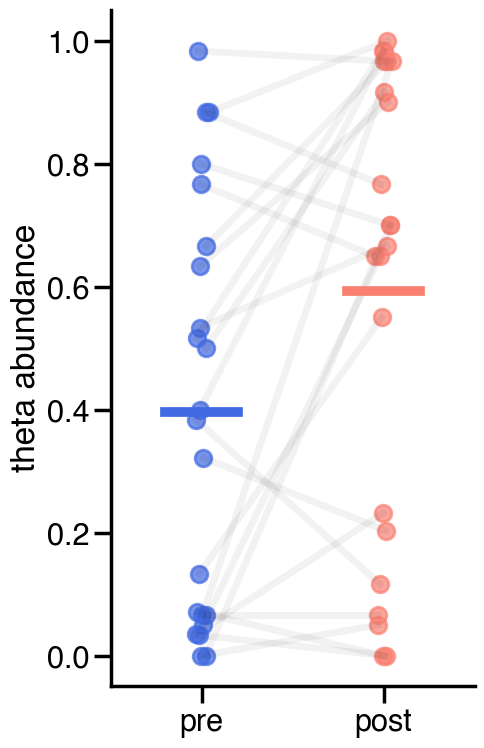

In [92]:
plot_feature_prepost(theta_osc_perc, feature='ch_theta_perc')
plt.ylabel('theta abundance')
sns.despine()
plt.show()

In [93]:
perc_theta_pre = theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].values

In [94]:
print('pre: ' + str(round(perc_theta_pre.mean(),2)) + ' std: ' + str(round(perc_theta_pre.std(),2)))
print('post: ' + str(round(perc_theta_post.mean(),2)) + ' std: ' + str(round(perc_theta_post.std(),2)))

pre: 0.4 std: 0.33
post: 0.59 std: 0.37


In [95]:
print(normality(perc_theta_pre))
print(normality(perc_theta_post))

          W      pval  normal
0  0.892825  0.021416   False
          W      pval  normal
0  0.847951  0.003124   False


In [96]:
print('theta abundance pre')
print(theta_osc_perc[theta_osc_perc['pre_post']=='pre']['ch_theta_perc'].describe())

theta abundance pre
count    22.000000
mean      0.396781
std       0.337071
min       0.000000
25%       0.066667
50%       0.391667
75%       0.658333
max       0.983333
Name: ch_theta_perc, dtype: float64


In [97]:
print('theta abundance post')
print(theta_osc_perc[theta_osc_perc['pre_post']=='post']['ch_theta_perc'].describe())

theta abundance post
count    22.000000
mean      0.592524
std       0.374113
min       0.000000
25%       0.210578
50%       0.683333
75%       0.954167
max       1.000000
Name: ch_theta_perc, dtype: float64


**Wilcoxon Test**

In [98]:
print(wilcoxon(perc_theta_pre, perc_theta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   47.0   two-sided  0.018085 -0.593074  0.331612


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [99]:
cliffs_delta(perc_theta_pre, perc_theta_post)

(-0.3367768595041322, 'medium')

**Permutation Test & T-Test**

The probability from the sampling statistics is =  0.0 

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.913894   21   two-sided  0.008299  [-0.34, -0.06]  0.549727  5.818   

           power  
T-test  0.691201  


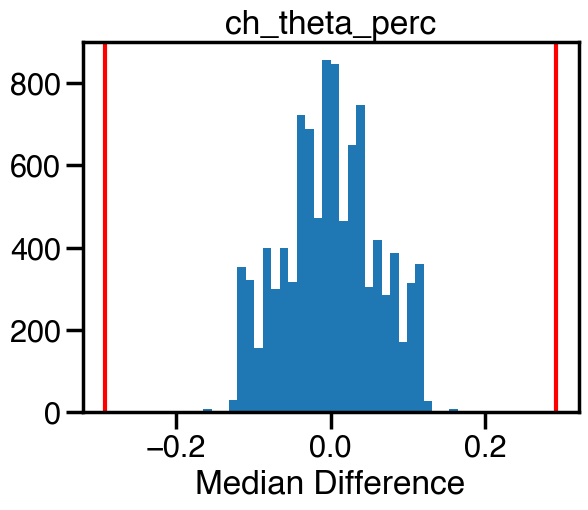

In [100]:
perm_test(theta_osc_perc, feature='ch_theta_perc')

### Alpha Percentage

In [101]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have an alpha oscillation)

features = ['patient','pre_post','channel','alpha_cf']
exp_df_alpha_osc = exp_df_included[features]
exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11590/4032763983.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_df_alpha_osc['alpha_present'] = exp_df_alpha_osc['alpha_cf'].notna()


In [102]:
# With this new df, we want to group by the patient/pre_post to show how many channels have an alpha oscillation
# Also need to calculate the total # of channels b/c need to get a percentage 
# (not all pts have same # of channels due to exclusion criteria)

ch_alpha = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['alpha_present'].sum().values
ch_total = exp_df_alpha_osc.groupby(['patient', 'pre_post'])['channel'].count().values

ch_alpha_perc = ch_alpha/ch_total

In [103]:
# Add the alpha oscillation percentages to the other df to determine which value corresponds to pre/post

alpha_osc_perc = pd.DataFrame(exp_df_alpha_osc.groupby(['patient', 'pre_post'], as_index=False)['alpha_present'].sum())
alpha_osc_perc['ch_alpha_perc'] = ch_alpha_perc

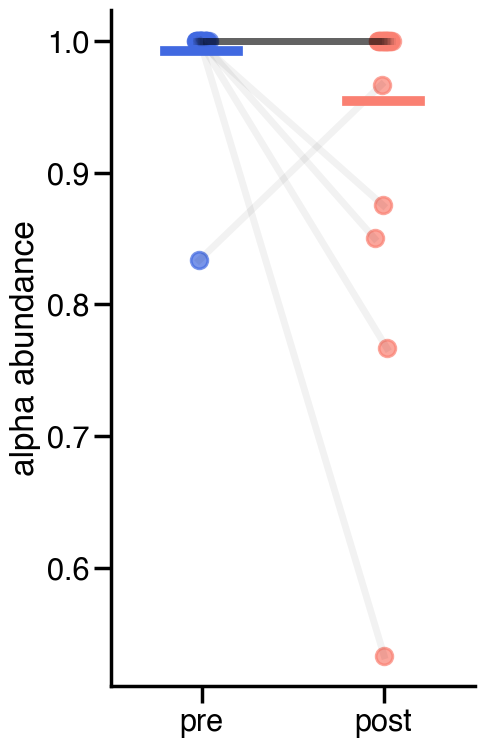

In [104]:
plot_feature_prepost(alpha_osc_perc, feature='ch_alpha_perc')
plt.ylabel('alpha abundance')
sns.despine()
plt.show()

In [105]:
perc_alpha_pre = alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].values

In [106]:
print('pre: ' + str(round(perc_alpha_pre.mean(),2)) + ' std: ' + str(round(perc_alpha_pre.std(),2)))
print('post: ' + str(round(perc_alpha_post.mean(),2)) + ' std: ' + str(round(perc_alpha_post.std(),2)))

pre: 0.99 std: 0.03
post: 0.95 std: 0.11


In [107]:
print('alpha abundance pre:')
print(alpha_osc_perc[alpha_osc_perc['pre_post']=='pre']['ch_alpha_perc'].describe())

alpha abundance pre:
count    22.000000
mean      0.992424
std       0.035533
min       0.833333
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: ch_alpha_perc, dtype: float64


In [108]:
print('alpha abundance post:')
print(alpha_osc_perc[alpha_osc_perc['pre_post']=='post']['ch_alpha_perc'].describe())

alpha abundance post:
count    22.000000
mean      0.954167
std       0.112386
min       0.533333
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: ch_alpha_perc, dtype: float64


**Wilcoxon Test**

In [109]:
print(wilcoxon(perc_alpha_pre, perc_alpha_post))

          W-val alternative    p-val       RBC      CLES
Wilcoxon    2.0   two-sided  0.17753  0.733333  0.589876


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [110]:
cliffs_delta(perc_alpha_pre, perc_alpha_post)

(0.1797520661157025, 'small')

**Permutation Test & T-Test**

The probability from the sampling statistics is =  2.0 

               T  dof alternative     p-val          CI95%   cohen-d BF10  \
T-test  1.511638   21   two-sided  0.145529  [-0.01, 0.09]  0.459019  0.6   

           power  
T-test  0.537507  


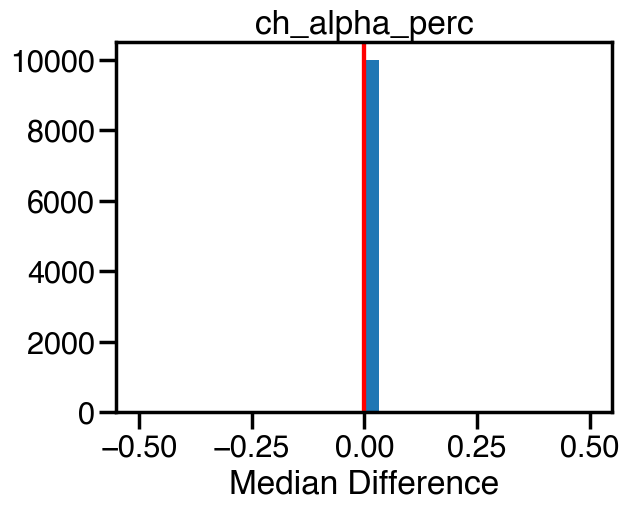

In [111]:
perm_test(alpha_osc_perc, feature='ch_alpha_perc')

## Merge Percentage Oscillation Dataframes

In [112]:
# merge percentage dfs
perc_df = pd.merge(theta_osc_perc, delta_osc_perc, how='outer', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_osc_perc, how='outer', on=['patient', 'pre_post'])

In [113]:
# merge perc with main eeg feature df
exp_df_mean_wperc = pd.merge(exp_df_mean, perc_df, how='outer', on=['patient', 'pre_post'])

In [114]:
exp_df_mean_wperc.head()

,patient,pre_post,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_bw,alpha_cf,theta_present,ch_theta_perc,delta_present,ch_delta_perc,alpha_present,ch_alpha_perc
0,9,post,1.128304,-11.424854,NaN,-11.756255,0.532759,-11.790756,5.611765,NaN,1.058285,-11.688802,2.464601,9.304229,55,0.916667,0,0.000000,60,1.000
1,9,pre,1.473953,-10.917829,0.146205,-11.321277,0.406346,-11.572985,5.350125,2.005953,1.024964,-11.451574,3.584126,9.112030,30,0.500000,2,0.033333,60,1.000
2,10,post,0.893403,-12.310575,0.541209,-12.618929,NaN,-12.962006,NaN,1.010379,0.411048,-12.909554,2.054040,9.798821,0,0.000000,3,0.053571,49,0.875
3,10,pre,0.918883,-12.048699,0.040532,-12.365095,0.186566,-12.690452,6.482045,2.453152,0.544295,-12.532217,2.443360,9.555304,4,0.071429,4,0.071429,56,1.000
4,18,post,1.094980,-11.289992,0.139738,-11.638065,0.489579,-11.971259,6.424628,1.017573,1.112956,-11.496834,1.591604,8.759194,7,0.116667,1,0.016667,60,1.000


## Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the band power differences pre vs. post?

### Using Treatment Difference

**Take difference of pre - post**

In [115]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf', 'ch_theta_perc', 'ch_delta_perc', 'ch_alpha_perc']


diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')
diff_df_mean_wperc['patient'] = exp_df_mean_wperc['patient']

diff_df_mean_wperc

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_11590/1529135655.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean_wperc = exp_df_mean_wperc.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')


,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_cf,ch_theta_perc,ch_delta_perc,ch_alpha_perc,patient
1,0.345650,0.507025,NaN,0.434978,-0.126412,0.217771,-0.261639,NaN,-0.033322,0.237228,-0.192200,-0.416667,0.033333,0.000000,9
3,0.025480,0.261876,-0.500677,0.253834,NaN,0.271554,NaN,1.442773,0.133247,0.377337,-0.243517,0.071429,0.017857,0.125000,10
5,0.115917,0.042335,-0.139468,-0.026524,-0.142296,0.134673,-1.167935,1.732426,0.012112,-0.016471,-0.024780,0.266667,0.000000,0.000000,18
7,-0.184502,-0.369752,NaN,-0.379509,-0.236117,-0.450002,0.208337,NaN,0.285625,-0.103030,0.006089,0.000000,0.000000,0.000000,22
9,0.014182,0.466595,NaN,0.494483,0.107728,0.323614,1.483624,NaN,-0.779568,-0.284728,-0.800650,0.118644,-0.033898,0.000000,25
11,-0.494473,-0.526216,NaN,-0.522628,-0.440249,-0.488498,-0.152538,NaN,0.204019,0.044466,0.058184,-0.266667,-0.133333,0.000000,33
13,-0.138135,-0.224031,-0.082597,-0.257054,-0.370930,-0.371153,-0.376757,0.095263,0.103503,0.007112,-0.089036,-0.583333,0.066667,0.466667,35
15,-0.036711,-0.005157,NaN,0.004755,-0.057284,-0.025370,-0.021891,NaN,0.087367,0.072388,-0.023627,-0.116667,0.000000,0.000000,46
17,0.144388,0.266258,-0.043819,0.160960,NaN,0.344395,NaN,1.928677,-0.289977,0.098429,-0.626846,0.033333,0.183333,0.000000,47
19,0.032645,-0.002819,-0.069863,0.011756,-0.244627,-0.245605,0.226827,-1.129617,-0.235628,-0.237180,-0.093968,0.100000,-0.016667,0.000000,53


In [116]:
# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + delta_amp + ch_delta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     7.468
Date:                Fri, 07 Jul 2023   Prob (F-statistic):             0.0189
Time:                        14:20:38   Log-Likelihood:                 2.4742
No. Observations:                  10   AIC:                             3.052
Df Residuals:                       6   BIC:                             4.262
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0895      0.141     -0.633

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [117]:
model.pvalues

Intercept        0.550249
exponent         0.006221
delta_amp        0.442501
ch_delta_perc    0.712537
dtype: float64

In [118]:
model = ols('theta_bp ~ exponent + theta_amp + ch_theta_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     47.33
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           1.42e-07
Time:                        14:20:38   Log-Likelihood:                 14.326
No. Observations:                  18   AIC:                            -20.65
Df Residuals:                      14   BIC:                            -17.09
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0917      0.050      1.827

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [119]:
model.pvalues

Intercept        0.089111
exponent         0.001729
theta_amp        0.000101
ch_theta_perc    0.248930
dtype: float64

In [120]:
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', diff_df_mean_wperc).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     6.626
Date:                Fri, 07 Jul 2023   Prob (F-statistic):            0.00329
Time:                        14:20:38   Log-Likelihood:                 12.201
No. Observations:                  22   AIC:                            -16.40
Df Residuals:                      18   BIC:                            -12.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0226      0.041      0.555

In [121]:

model.pvalues

Intercept        0.585932
exponent         0.004572
alpha_amp        0.000422
ch_alpha_perc    0.732356
dtype: float64

# Standardized Beta Coefficients

In [136]:
features = ['exponent', 'delta_bp', 'delta_amp', 'ch_delta_perc']

# standardizing dataframe
df_z = diff_df_mean_wperc[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + delta_amp + ch_delta_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     7.468
Date:                Fri, 07 Jul 2023   Prob (F-statistic):             0.0189
Time:                        14:33:04   Log-Likelihood:                -6.4156
No. Observations:                  10   AIC:                             20.83
Df Residuals:                       6   BIC:                             22.04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.776e-17      0.188   1.48e-16

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [137]:
features = ['exponent', 'theta_bp', 'theta_amp', 'ch_theta_perc']

# standardizing dataframe
df_z = diff_df_mean_wperc[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('theta_bp ~ exponent + theta_amp + ch_theta_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     47.33
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           1.42e-07
Time:                        14:34:16   Log-Likelihood:                -3.8448
No. Observations:                  18   AIC:                             15.69
Df Residuals:                      14   BIC:                             19.25
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.939e-17      0.080   8.67e-16

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [138]:
features = ['exponent', 'alpha_bp', 'alpha_amp', 'ch_alpha_perc']

# standardizing dataframe
df_z = diff_df_mean_wperc[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     6.626
Date:                Fri, 07 Jul 2023   Prob (F-statistic):            0.00329
Time:                        14:34:38   Log-Likelihood:                -23.033
No. Observations:                  22   AIC:                             54.07
Df Residuals:                      18   BIC:                             58.43
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept              0      0.162          0